In [1]:
import scCube
from scCube import scCube
from scCube.visualization import *
from scCube.utils import *
from matplotlib.pyplot import rc_context
import pandas as pd
import scanpy as sc
import numpy as np
import warnings
import time
warnings.filterwarnings("ignore")

/home/qjy/anaconda3/envs/sccube/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = scCube()

In [3]:
sc_data = pd.read_csv('/home/qjy/workspace/scCube/scCube/tutorial/demo_data/demo_merfish_data.csv', index_col=0)
sc_meta = pd.read_csv('/home/qjy/workspace/scCube/scCube/tutorial/demo_data/demo_merfish_meta.csv', index_col=0)

sc_adata = model.pre_process(sc_data=sc_data, 
                             sc_meta=sc_meta,
                             is_normalized=False)

sc_adata.layers["log_transformed"] = sc_adata.X
sc_data_norm = sc_adata.to_df(layer="log_transformed").T

the input is count matrix, normalizing it firstly...


In [4]:
model_name = 'demo_merfish_epoch10000'
generate_sc_meta, generate_sc_data = model.train_vae_and_generate_cell(
    sc_adata=sc_adata,
    celltype_key='Cell_type',
    cell_key='Cell',
    target_num=None,
    batch_size=512,
    epoch_num=10000,
    lr=0.0001,
    hidden_size=128,
    save_model=True,
    save_path='/home/qjy/workspace/scCube/save_model',
    project_name=model_name,
    used_device='cuda:1')

generating by the proportion of cell types of the input scRNA-seq data...
begin vae training...


Train Epoch: 9999: 100%|██████████| 10000/10000 [02:49<00:00, 59.03it/s, loss=0.7466, min_loss=0.7428]


vae training done!
saving the trained vae model...
save trained vae in /home/qjy/workspace/scCube/save_model/demo_merfish_epoch10000.pth.


Generate Epoch: 0: 100%|██████████| 1000/1000 [00:00<00:00, 75886.16it/s]

generated done!
data have been prepared!


In [5]:
generate_sc_data, generate_sc_meta = model.generate_pattern_reference(
        sc_adata=sc_adata,
        generate_sc_data=generate_sc_data,
        generate_sc_meta=generate_sc_meta,
        celltype_key='Cell_type',
        spatial_key=['x', 'y'],
        cost_metric='sqeuclidean'
)

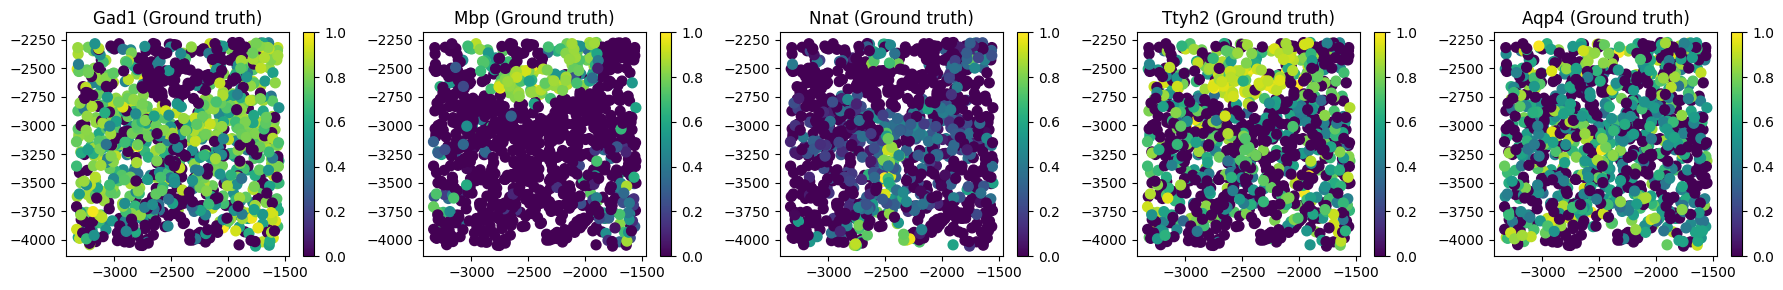

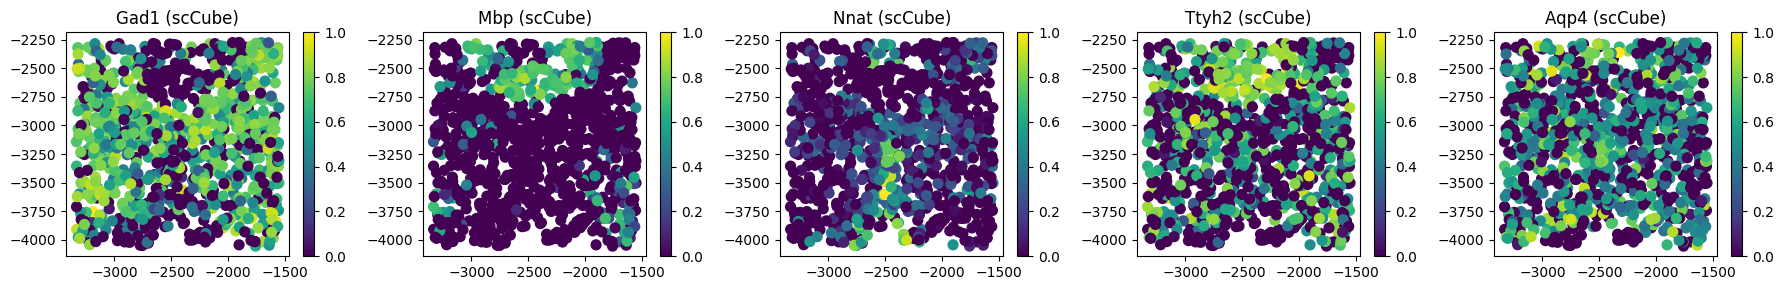

In [6]:
genes = ['Gad1', 'Mbp', 'Nnat', 'Ttyh2', 'Aqp4']

# real data
obj = sc_meta
obj.index = list(obj['Cell'])
gene_exp = sc_data_norm.T[genes]
x = obj['x']
y = obj['y']
fig, axes = plt.subplots(1,5,figsize=(18, 3))

for i in range(len(genes)):
    gene_exp_tmp = gene_exp[genes[i]]
    gene_exp_tmp = (gene_exp_tmp - gene_exp_tmp.min()) / (gene_exp_tmp.max() - gene_exp_tmp.min())
    g = axes[i].scatter(x, y, s=50, cmap='viridis', c=gene_exp_tmp)
    axes[i].set_title(genes[i] + ' (Ground truth)')
    fig.colorbar(g, ax=axes[i])

plt.tight_layout()

# scCube
obj = generate_sc_meta
obj.index = list(obj['Cell'])
gene_exp = generate_sc_data.T[genes]
x = obj['x']
y = obj['y']
fig, axes = plt.subplots(1,5, figsize=(18, 3))

for i in range(len(genes)):
    gene_exp_tmp = gene_exp[genes[i]]
    gene_exp_tmp = (gene_exp_tmp - gene_exp_tmp.min()) / (gene_exp_tmp.max() - gene_exp_tmp.min())
    g = axes[i].scatter(x, y, s=50, cmap='viridis', c=gene_exp_tmp)
    axes[i].set_title(genes[i] + ' (scCube)')
    fig.colorbar(g, ax=axes[i])

plt.tight_layout()
plt.show()

In [7]:
# sc.pp.highly_variable_genes(sc_adata, flavor="seurat_v3", n_top_genes=2000)
# sc_adata = sc_adata[:, sc_adata.var.highly_variable]
sc.pp.scale(sc_adata, max_value=10)
sc.tl.pca(sc_adata, svd_solver='arpack')
sc.pp.neighbors(sc_adata)
sc.tl.umap(sc_adata)

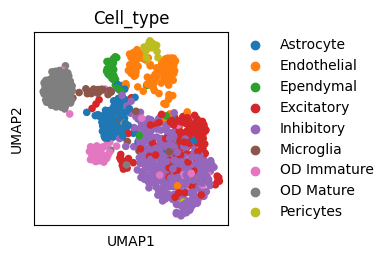

In [8]:
with rc_context({'figure.figsize': (2.5, 2.5)}):
    sc.pl.umap(sc_adata, color='Cell_type')

In [9]:
# avoid error in sc_adata.concatenate(sc_adata_generate, batch_categories=['real', 'generate'])
generate_sc_meta_rep = generate_sc_meta.set_index(keys='Cell', drop=False)
sc_adata_generate = model.pre_process(sc_data=generate_sc_data, 
                                      sc_meta=generate_sc_meta_rep,
                                      is_normalized=True)

# sc.pp.highly_variable_genes(sc_adata_generate, flavor="seurat_v3", n_top_genes=2000)
# sc_adata_generate = sc_adata_generate[:, sc_adata_generate.var.highly_variable]
sc.pp.scale(sc_adata_generate, max_value=10)
sc.tl.pca(sc_adata_generate, svd_solver='arpack')
sc.pp.neighbors(sc_adata_generate)
sc.tl.umap(sc_adata_generate)

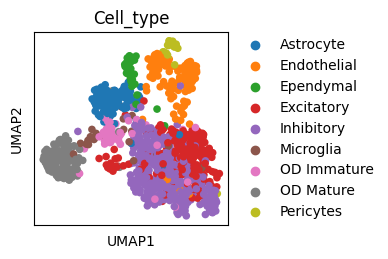

In [10]:
with rc_context({'figure.figsize': (2.5, 2.5)}):
    sc.pl.umap(sc_adata_generate, color='Cell_type')

In [11]:
adata_concat = sc_adata.concatenate(sc_adata_generate, batch_categories=['real', 'generate'])
sc.tl.pca(adata_concat)
sc.pp.neighbors(adata_concat)
sc.tl.umap(adata_concat)

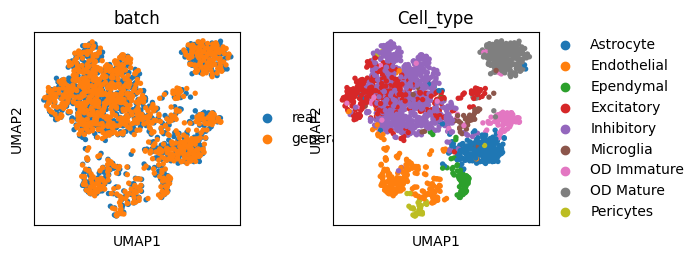

In [12]:
with rc_context({'figure.figsize': (2.5, 2.5)}):
    sc.pl.umap(adata_concat, color=['batch', 'Cell_type'])